# Libraries

In [1]:
from annotations_validation import check_annotations
import EDF_wrapper
import filters
import pyedflib
import plotly.express as px
from pathlib import Path
import os
import pandas as pd
import numpy as np
import re
from SwallowDetection.SwallowAnntations import get_swallow_annotations

In [2]:
def add_swallow_annotations(files: list, output_path:str="data/annotated/"):
    
    # Extract annotations from signal
    ann = []    
    for edf_file in np.asarray([file['filepath'] for file in files]):
        try:
            ann.append(get_swallow_annotations(edf_file))
        except:
            print(f"File {edf_file} failed to get swallow annotations.")
    
    os.makedirs(output_path, exist_ok=True)
    for file, (times, annotations) in zip(files, ann):
        # Add extracted annotations to file's annotation list
        for time, annotation in zip(times, annotations):
            file['header']['annotations'].append([time, -1, annotation])
            
        file['header']['annotations'].sort(key=lambda x: x[0])
        # Save edited edf file
        EDF_wrapper.save_edf_file(file, output_path=output_path)

In [3]:
directory = Path("data/edf/")
files = EDF_wrapper.read_files_from_dir(directory, load_files=True)
len(files)

7

c:\Users\mat49681\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\mat49681\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.2.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\mat49681\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.0 when using version 1.0.2. This might lead to brea

File data\edf\SleepLabData.edf failed to get swallow annotations.


c:\Users\mat49681\Anaconda3\lib\site-packages\pyedflib\edfwriter.py:92: UserWarning: Physical minimum for channel 0 (EMG 1) is -4.255166009376407, which has 18 chars, however, EDF+ can only save 8 chars, will be truncated to -4.25516, some loss of precision is to be expected
  warnings.warn('Physical minimum for channel {} ({}) is {}, which has {} chars, '\
c:\Users\mat49681\Anaconda3\lib\site-packages\pyedflib\edfwriter.py:99: UserWarning: Physical minimum for channel 0 (EMG 1) is 1.1026859940699335e-05, which has 22 chars, however, EDF+ can only save 8 chars, will be truncated to 1.102685, some loss of precision is to be expected.
  warnings.warn('Physical minimum for channel {} ({}) is {}, which has {} chars, '\
c:\Users\mat49681\Anaconda3\lib\site-packages\pyedflib\edfwriter.py:92: UserWarning: Physical minimum for channel 1 (EMG 3) is -106.9169081399982, which has 18 chars, however, EDF+ can only save 8 chars, will be truncated to -106.916, some loss of precision is to be expected

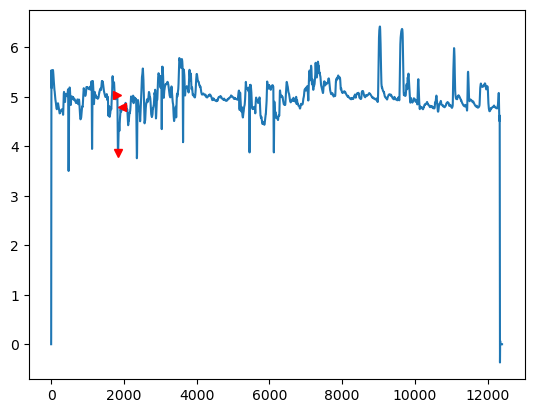

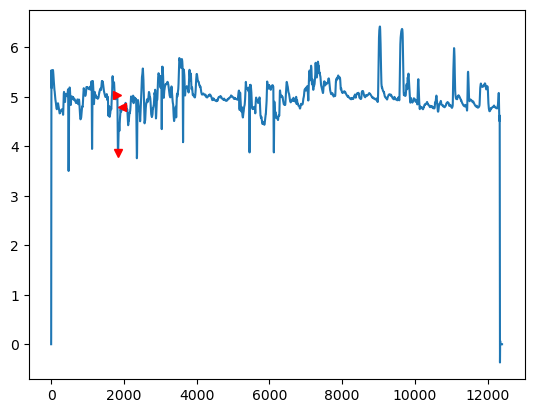

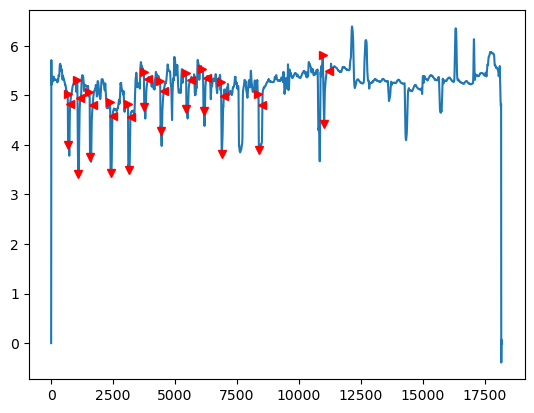

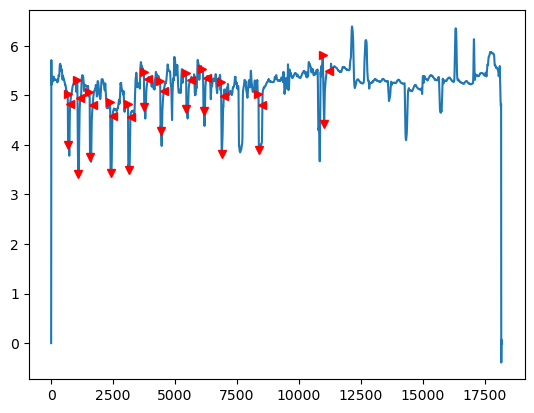

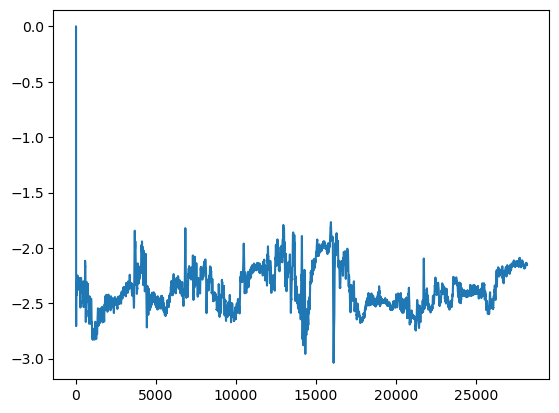

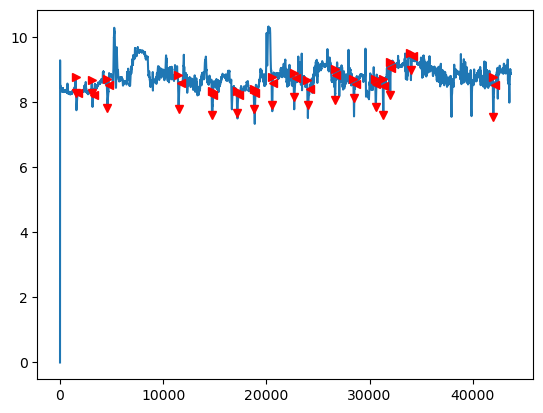

In [4]:
add_swallow_annotations(files)

In [6]:
directory = Path("data/annotations/")
annotated_files = EDF_wrapper.read_files_from_dir(directory, load_files=True)
len(annotated_files)

6

In [7]:
def compute_time(sampling_frequency, signal_array):
        # Calculate the time array based on the length of the signal array and the sampling frequency
        total_samples = len(signal_array)
        time_array = np.arange(total_samples) / sampling_frequency
        
        return time_array
    
def find_first_element(list_data, condition):
        for element in list_data:
            if condition(element):
                return element
        return None

In [19]:
def create_annotations_df(file, df_type='general', fileList=False):
    
    def crop_signals_array(start_time, stop_time, file):
        cropped_signals = []
        for channel, signal in enumerate(file["signals"]):
            sr = file['signal_headers'][channel]['sample_rate']
            start_idx = round(start_time * sr)
            stop_idx = round(stop_time * sr) + 1
            time_array = compute_time(sr, signal)
            cropped_signals.append((time_array[start_idx: stop_idx], np.array(signal[start_idx: stop_idx])))
            
        return list(zip(file['signal_headers'], np.array(cropped_signals)))
    
    if df_type == 'general':
        match_pattern = "[ctp]_"
    else:
        match_pattern = "[cs]_"

    general = list(filter(lambda x : re.match(match_pattern, x[-1]), file["header"]["annotations"]))

    id_rows = {"set": [], "subject": [], "category": [], "sample_name": [],
            "start_time": [], "stop_time": [],
             }
    
    signal_rows = {"id": [],
             "data_label": [],
             "time": [],
             "signal": []
             }
    
    cat = '-'
    id = -1
    for i, row in enumerate(general):
        time, _, desc = row
        s = desc.split("_")
        t, sample, event = s
        
        if t == "c":
            if event == "start":
                _, cat, _ = s
            else:
                cat = '-'
            
        else:
            if event == "start":
                start_time = time
                stop_time, _, _ = find_first_element(general[i:], lambda x: x[-1] == f"{t}_{sample}_stop")
                if not fileList:
                    id += 1
                    signals = crop_signals_array(start_time, stop_time, file)
                                            
                    id_rows["set"].append(1)
                    id_rows["subject"].append(Path(file["filepath"]).stem)
                    id_rows["category"].append(cat)
                    id_rows["sample_name"].append(s[1])
                    id_rows["start_time"].append(start_time)
                    id_rows["stop_time"].append(stop_time)
                    
                    for h, sigs in signals:
                        signal_rows["id"].append(id)
                        signal_rows["data_label"].append(h['label'])
                        signal_rows["time"].append(sigs[0])
                        signal_rows["signal"].append(sigs[1])

    main_df = pd.DataFrame(id_rows)
    
    signals_df = pd.DataFrame(signal_rows)
    
    df = main_df.merge(signals_df, left_index=True, right_on='id')
    
    #df.drop('id', axis=1, inplace=True)
    
    # df = df.explode(['time', 'signal']).reset_index(drop=True)
    
    # df["id"] = (df["subject"] + df["category"] + df["sample_name"]).astype("category")
    # df["data_label"] = df["data_label"].astype("category")
    
    # df["time"] = df["time"].astype(float)
    # df["signal"] = df["signal"].astype(float)
    
    # cat_columns = df.select_dtypes(['category']).columns

    # df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
    
    # df['duration'] = df["stop_time"] - df["start_time"]
     
    return df
    #return main_df, signals_df

In [20]:
ann_file = annotated_files[1]
ann_file

{'filepath': 'data\\annotations\\1-1-Bewegung_edited.bdf',
 'signals': array([[-2.65346664e+00, -4.09815972e+00, -4.09921836e+00, ...,
          1.10000000e-05,  1.10000000e-05,  1.10000000e-05],
        [-1.54232685e+00, -1.44602274e+00, -1.44344180e+00, ...,
          1.10000000e-05,  1.10000000e-05,  1.10000000e-05],
        [-3.29886942e+00,  4.98973153e+00,  4.99647033e+00, ...,
          7.62355993e-06,  7.62355993e-06,  7.62355993e-06],
        [-4.99413000e+00, -5.02254299e-02, -4.44210468e-02, ...,
          8.35312535e-06,  8.35312535e-06,  8.35312535e-06],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
 'signal_headers': [{'label': 'EMG 1',
   'dimension': 'mV',
   'sample_rate': 4000.0,
   'sample_frequency': 4000.0,
   'physical_max': 1.1e-05,
   'physical_min': -4.25516,
   'digital_max': 8388607,
   'digital_min': -8388608,
   'prefilter': '',
   'transducer': 'transkutan'},
  {'label': 'EMG

In [21]:
ann_file["header"]["annotations"] = list(map(lambda x: [x[0], x[1], x[2].lower()], ann_file["header"]["annotations"]))
ann_file["header"]["annotations"]

[[1.6465, -1.0, 'schlucken normal'],
 [4.027, -1.0, 'c_category1_start'],
 [4.646, -1.0, 'p_elevation_start'],
 [4.646, -1.0, 'p_swallow_start'],
 [4.768, -1.0, 'p_elevation_stop'],
 [4.768, -1.0, 'p_lowering_start'],
 [4.996, -1.0, 'p_lowering_stop'],
 [4.996, -1.0, 'p_swallow_stop'],
 [6.9507, -1.0, 'stop'],
 [8.94, -1.0, 'schlucken normal'],
 [11.11, -1.0, 'p_elevation_start'],
 [11.223, -1.0, 'p_elevation_stop'],
 [11.223, -1.0, 'p_lowering_start'],
 [11.413, -1.0, 'p_lowering_stop'],
 [11.913, -1.0, 'c_category1_stop'],
 [12.9407, -1.0, 'stop'],
 [15.109, -1.0, 'schlucken hoch'],
 [18.18, -1.0, 's_swallow_start'],
 [19.51, -1.0, 's_swallow_stop'],
 [19.5507, -1.0, 'stop'],
 [21.9807, -1.0, 'schlucken hoch'],
 [25.2005, -1.0, 'stop'],
 [27.386, -1.0, 'schlucken tief'],
 [31.415, -1.0, 'stop'],
 [33.6, -1.0, 'schlucken tief'],
 [36.6657, -1.0, 'stop'],
 [51.646, -1.0, 'mendelson'],
 [53.711, -1.0, 'c_category2_start'],
 [54.376, -1.0, 'p_elevation_start'],
 [54.376, -1.0, 'p_swallow

In [22]:
check_annotations(ann_file)

There are 36 annotations out of the pattern.


True

In [38]:
general_df = create_annotations_df(ann_file, 'general')
swallows_df = create_annotations_df(ann_file, 'swallows')

In [48]:
general_df

,set,subject,category,sample_name,start_time,stop_time,id,data_label,time,signal
0,1,1-1-Bewegung_edited,category1,elevation,4.646,4.768,0,EMG 1,"[4.646, 4.64625, 4.6465, 4.64675, 4.647, 4.647...","[-4.108591185448896, -4.097652464686302, -4.07..."
1,1,1-1-Bewegung_edited,category1,elevation,4.646,4.768,0,EMG 3,"[4.646, 4.64625, 4.6465, 4.64675, 4.647, 4.647...","[-106.69195529420544, -106.68831648750951, -10..."
2,1,1-1-Bewegung_edited,category1,elevation,4.646,4.768,0,BI 1,"[4.646, 4.64625, 4.6465, 4.64675, 4.647, 4.647...","[5.101975874134057, 5.0936533940237405, 5.0782..."
3,1,1-1-Bewegung_edited,category1,elevation,4.646,4.768,0,BI 2,"[4.646, 4.64625, 4.6465, 4.64675, 4.647, 4.647...","[0.24088637737908214, 0.2563484669177809, 0.26..."
4,1,1-1-Bewegung_edited,category1,elevation,4.646,4.768,0,sync,"[4.646, 4.64625, 4.6465, 4.64675, 4.647, 4.647...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,1,1-1-Bewegung_edited,category1,swallow,4.646,4.996,1,EMG 1,"[4.646, 4.64625, 4.6465, 4.64675, 4.647, 4.647...","[-4.108591185448896, -4.097652464686302, -4.07..."
6,1,1-1-Bewegung_edited,category1,swallow,4.646,4.996,1,EMG 3,"[4.646, 4.64625, 4.6465, 4.64675, 4.647, 4.647...","[-106.69195529420544, -106.68831648750951, -10..."
7,1,1-1-Bewegung_edited,category1,swallow,4.646,4.996,1,BI 1,"[4.646, 4.64625, 4.6465, 4.64675, 4.647, 4.647...","[5.101975874134057, 5.0936533940237405, 5.0782..."
8,1,1-1-Bewegung_edited,category1,swallow,4.646,4.996,1,BI 2,"[4.646, 4.64625, 4.6465, 4.64675, 4.647, 4.647...","[0.24088637737908214, 0.2563484669177809, 0.26..."
9,1,1-1-Bewegung_edited,category1,swallow,4.646,4.996,1,sync,"[4.646, 4.64625, 4.6465, 4.64675, 4.647, 4.647...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [52]:
test = general_df.explode(['time', 'signal'])
test['id'] = test.index

In [53]:
test

,set,subject,category,sample_name,start_time,stop_time,id,data_label,time,signal
0,1,1-1-Bewegung_edited,category1,elevation,4.646,4.768,0,EMG 1,4.646,-4.108591
0,1,1-1-Bewegung_edited,category1,elevation,4.646,4.768,0,EMG 1,4.64625,-4.097652
0,1,1-1-Bewegung_edited,category1,elevation,4.646,4.768,0,EMG 1,4.6465,-4.078907
0,1,1-1-Bewegung_edited,category1,elevation,4.646,4.768,0,EMG 1,4.64675,-4.061462
0,1,1-1-Bewegung_edited,category1,elevation,4.646,4.768,0,EMG 1,4.647,-4.055221
...,...,...,...,...,...,...,...,...,...,...
44,1,1-1-Bewegung_edited,-,movement,95.714,96.955,44,sync,96.954,0.0
44,1,1-1-Bewegung_edited,-,movement,95.714,96.955,44,sync,96.95425,0.0
44,1,1-1-Bewegung_edited,-,movement,95.714,96.955,44,sync,96.9545,0.0
44,1,1-1-Bewegung_edited,-,movement,95.714,96.955,44,sync,96.95475,0.0


In [54]:
test["id"] = (test['id']).astype("int")
#test["data_label"] = test["data_label"].astype("category")

test["time"] = test["time"].astype(float)
test["signal"] = test["signal"].astype(float)

#cat_columns = test.select_dtypes(['category']).columns

#test[cat_columns] = test[cat_columns].apply(lambda x: x.cat.codes)

## TSFresh tests

In [27]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, EfficientFCParameters

In [55]:
test.dtypes

set              int64
subject         object
category        object
sample_name     object
start_time     float64
stop_time      float64
id               int32
data_label      object
time           float64
signal         float64
dtype: object

## To-do:
- Define the parameters to keep in the excel file
- Create a function that takes the annotations dfs and returns the feature-extracted df from tsfresh

In [57]:
# Define your extraction settings (optional)
extraction_settings = EfficientFCParameters()

# # Remove the 'sample_entropy' calculation from the extraction settings
# extraction_settings.pop('sample_entropy', None)

# Perform feature extraction without the 'sample_entropy' calculation
X = extract_features(test, column_id='id', column_sort='time',
                     column_kind=None, column_value='signal',
                     default_fc_parameters=extraction_settings,
                     impute_function=impute
                     )

Feature Extraction:   0%|          | 0/23 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 23/23 [00:07<00:00,  3.22it/s]


In [62]:
out_df = general_df.merge(X, left_on='id', right_index=True)
out_df.drop(['id', 'time', 'signal'], axis=1, inplace=True)

In [64]:
out_df.to_excel(f"data/xlsx/{Path(ann_file['filepath']).stem}.xlsx")